# 旅游企业客户洞察案例

## 案例说明

##### 一家跨国旅游企业相对公司近8年历史消费客户做一个分析,了解客户的特征，从而针对不同客户的特征做出相应的营销策略，最大化投入产出比。通过识别高价值、高潜力的客户，实行差异化的客户管理策略，优化客户体验。为了实现这一目标，通过客户分群技术，将具有相似特征的客户聚到相同类中，为每个不同特点的客户群体提供具有针对性的、个性化的营销和管理活动.

##### 在对客户进行分群之前，我们先来了解客户数据构成。该客户数据主要包括客户系统中存储的客户历史消费记录,个人基本信息，家庭经济情况，兴趣爱好等，如下所示。

|字段|含义|类型|
|:--:|:--:|:--:|
|interested_travel |旅行偏好|二分类|
|computer_owner |是否有家用电脑|二分类|
|age |估计的年龄|连续|
|home_value |房产价格|连续|
|loan_ratio|贷款比率|连续|
|risk_score |风险分数|连续|
|marital |婚姻状况估计|连续|
|interested_sport |运动偏好|连续|
|HH_grandparent|户主祖父母是否健在估计|连续|
|HH_dieting |户主节食偏好|连续|
|HH_head_age|户主年龄|连续|
|auto_member |驾驶俱乐部估计|连续|
|interested_golf |高尔夫偏好|二分类|
|interested_gambling |博彩偏好|二分类|
|HH_has_children |户主是否有孩子|二分类|
|HH_adults_num |家庭成年人数量|连续|
|interested_reading |阅读偏好|有序分类|

## 建模分析思路:

### 1、数据集中的变量较多，如果全部进入模型会导致模型解释困难。因此，一方面我们对于有相关性的变量进行降维，减少变量数目；另一方面，基于业务理解，我们预先将变量进行分组，使得同一组的变量能尽量解释业务的一个方面。比如本例中将变量分成三组，分别是家庭基本情况、财务状况和用户爱好，通过对每组变量分别进行聚类，获取用户的侧写，再将三个聚类结果进行综合，以获得较完整的用户画像。

### 2、本例中数据类型复杂，包含了连续变量、无序分类和有序分类变量。由于K-means最好仅用于连续型变量聚类，因此需要对变量进行预处理。对于有序分类变量，如果分类水平较多可以视作连续变量处理，否则视作无序分类变量一样处理，再进入模型；无序分类变量数目较少时，可以使用其哑变量编码进入模型。本例中由于有较多的二分类变量，又集中在用户爱好这一方面，因此我们将interested_reading这一有序分类变量二值化，再与其他几个二分类变量一起进行汇总，得到用户的“爱好广度”，使用“爱好广度”与其他连续型的爱好类变量进行聚类。

### 3、离散变量如HH_has_children一般不参与聚类，因为其本身就可以视作是簇的标签；如果为了后期解释模型时简化处理，在离散变量不多的情况之下，也可以做哑变量变换后进入模型。

## 读取数据

In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

travel=pd.read_csv('data_travel.csv',skipinitialspace=True)
travel.head()

,interested_travel,computer_owner,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,interested_golf,interested_gambling,HH_has_children,HH_adults_num,interested_reading
0,NaN,NaN,64,124035,73,932,3,312,420,149,96,626,0,0,NaN,NaN,0
1,0.0,1.0,69,138574,73,1000,7,241,711,263,68,658,0,0,N,5.0,3
2,0.0,0.0,57,148136,77,688,1,367,240,240,56,354,0,1,N,2.0,1
3,1.0,1.0,80,162532,74,932,7,291,832,197,86,462,1,1,Y,2.0,3
4,1.0,1.0,48,133580,77,987,10,137,121,209,42,423,0,1,Y,3.0,3


In [14]:
travel.describe(include='all')

,interested_travel,computer_owner,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,interested_golf,interested_gambling,HH_has_children,HH_adults_num,interested_reading
count,149788.000000,149788.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,159899,145906.000000,167177
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,3
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111462,NaN,65096
mean,0.427745,0.856571,59.507079,207621.314798,66.762707,817.031751,6.884015,259.431776,377.072498,204.593341,59.368023,486.861273,0.373012,0.357842,NaN,2.770832,NaN
std,0.494753,0.350511,14.311733,107822.501900,9.751835,165.490295,2.610552,78.867456,248.045395,78.971038,16.712912,151.167457,0.483607,0.479367,NaN,1.285417,NaN
min,0.000000,0.000000,18.000000,48910.000000,0.000000,1.000000,1.000000,60.000000,0.000000,47.000000,18.000000,49.000000,0.000000,0.000000,NaN,0.000000,NaN
25%,0.000000,1.000000,49.000000,135595.000000,63.000000,748.000000,5.000000,204.000000,182.000000,144.000000,48.000000,377.000000,0.000000,0.000000,NaN,2.000000,NaN
50%,0.000000,1.000000,59.000000,182106.000000,69.000000,844.000000,7.000000,251.000000,351.000000,185.000000,60.000000,492.000000,0.000000,0.000000,NaN,2.000000,NaN
75%,1.000000,1.000000,70.000000,248277.000000,73.000000,945.000000,9.000000,306.000000,528.000000,252.000000,71.000000,600.000000,1.000000,1.000000,NaN,4.000000,NaN


## 数据预处理

#### 填补缺失值

有缺失情况的变量皆为分类变量，且缺失比例并不高，因此用众数进行填补

In [15]:
fill_cols = ['interested_travel', 'computer_owner', 'HH_adults_num']
fill_values={col:travel[col].mode()[0] for col in fill_cols}
travel=travel.fillna(fill_values)

#### 修正错误值
1)HH_has_children的分类水平以字符形式表示，需要转换为整型，同时其中的缺失值应当表示没有小孩，因此替换为0；

2）阅读爱好interested_reading中包含错误值“.”，将其以0进行替换，代表该用户对阅读没有兴趣。

In [16]:
travel['interested_reading'].value_counts(dropna=False)

3    65096
1    43832
0    32919
2    24488
.      842
Name: interested_reading, dtype: int64

In [17]:
#修正错误值

travel['HH_has_children']=travel['HH_has_children'].replace({'N':0,'Y':1,np.NaN:0})
travel['interested_reading']=travel['interested_reading'].replace({'.':'0'}).astype('int')

In [18]:
travel.describe(include='all')

,interested_travel,computer_owner,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,interested_golf,interested_gambling,HH_has_children,HH_adults_num,interested_reading
count,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000
mean,0.383252,0.871489,59.507079,207621.314798,66.762707,817.031751,6.884015,259.431776,377.072498,204.593341,59.368023,486.861273,0.373012,0.357842,0.289735,2.672754,1.723299
std,0.486180,0.334658,14.311733,107822.501900,9.751835,165.490295,2.610552,78.867456,248.045395,78.971038,16.712912,151.167457,0.483607,0.479367,0.453641,1.228025,1.175929
min,0.000000,0.000000,18.000000,48910.000000,0.000000,1.000000,1.000000,60.000000,0.000000,47.000000,18.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,49.000000,135595.000000,63.000000,748.000000,5.000000,204.000000,182.000000,144.000000,48.000000,377.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,0.000000,1.000000,59.000000,182106.000000,69.000000,844.000000,7.000000,251.000000,351.000000,185.000000,60.000000,492.000000,0.000000,0.000000,0.000000,2.000000,2.000000
75%,1.000000,1.000000,70.000000,248277.000000,73.000000,945.000000,9.000000,306.000000,528.000000,252.000000,71.000000,600.000000,1.000000,1.000000,1.000000,3.000000,3.000000
max,1.000000,1.000000,99.000000,1000000.000000,102.000000,1000.000000,10.000000,920.000000,980.000000,633.000000,99.000000,878.000000,1.000000,1.000000,1.000000,7.000000,3.000000


#### 对离散型变量进行处理

- 使用k-means聚类，一般不分析离散变量，但可以根据业务理解，将离散型变量进行变换

- 先对interested_reading进行二值化

In [19]:
from sklearn.preprocessing import Binarizer

binarizer = Binarizer(threshold=1.5)
travel['interested_reading'] = binarizer.fit_transform(
    travel[['interested_reading']])

#### 结合前面的建模思路，我们可以将旅行，电脑，高尔夫，博彩，阅读这几个分类型变量综合成一个”爱好广度“指标，代表用户休闲娱乐爱好

- 生成二分类偏好填充率

In [21]:
interest =[
    'interested_travel',
    'computer_owner',
    'interested_golf', 
    'interested_gambling',
    'interested_reading'
]
n_ = len(interest)

travel = travel.drop(interest, axis=1).assign(interest=travel[interest].sum(axis=1) / n_)

In [22]:
travel.head()

,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,HH_has_children,HH_adults_num,interest
0,64,124035,73,932,3,312,420,149,96,626,0,2.0,0.2
1,69,138574,73,1000,7,241,711,263,68,658,0,5.0,0.4
2,57,148136,77,688,1,367,240,240,56,354,0,2.0,0.2
3,80,162532,74,932,7,291,832,197,86,462,1,2.0,1.0
4,48,133580,77,987,10,137,121,209,42,423,1,3.0,0.8


#### 正态化、标准化

- 在使用k-means进行用户分群时，对不同类型变量执行不同处理，连续变量、有序分类变量及无序分类变量在处理上均有不同，因此先按类型对变量分组，不同组采用不同的处理策略
- 如果一个连续变量的可能取值很少，如marital（10个水平）、interest（5个水平）、HH_adults_num（8个水平）等，当将其作为普通连续变量一样进行分布转换，可能生成一些离群值（例如对marital使用scikit-learn进行正态转换，会发现1和10对应的数据点离开均值达到5个标准差）。因此本例中将这几个连续变量作为有序分类变量对待，但不进行分布转化，仅做标准化处理。

In [23]:
continuous_cols = ['age', 'home_value', 'risk_score', 'interested_sport', 
                   'HH_dieting', 'auto_member', 'HH_grandparent',
                   'HH_head_age', 'loan_ratio']

categorical_cols = ['marital', 'interest', 'HH_adults_num']

discreate_cols = ['HH_has_children']

#### 正态化

为了聚类后的簇大小比较接近，对于偏态严重的连续变量应转换其分布，令其接近正态分布或均匀分布

- 对连续变量正态化

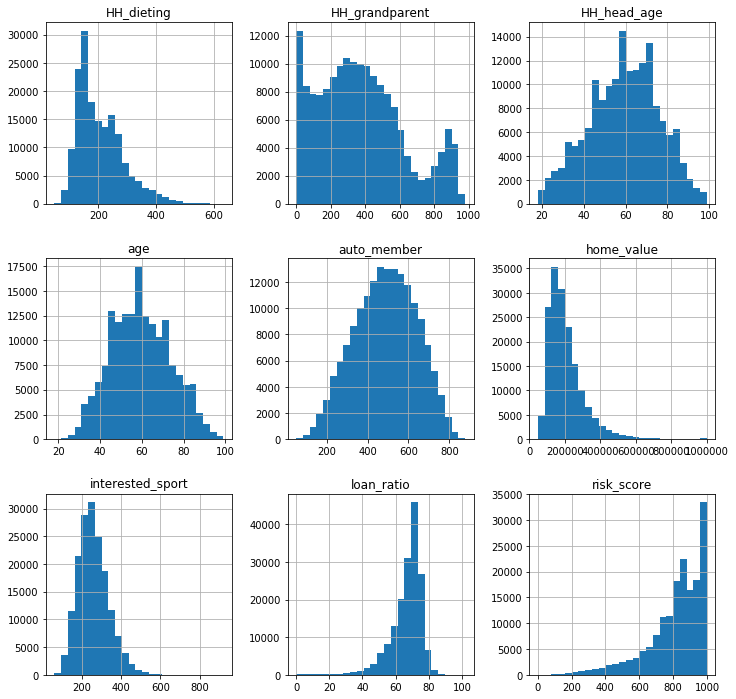

In [28]:
travel[continuous_cols].hist(bins=25,figsize=(12,12))
plt.show()

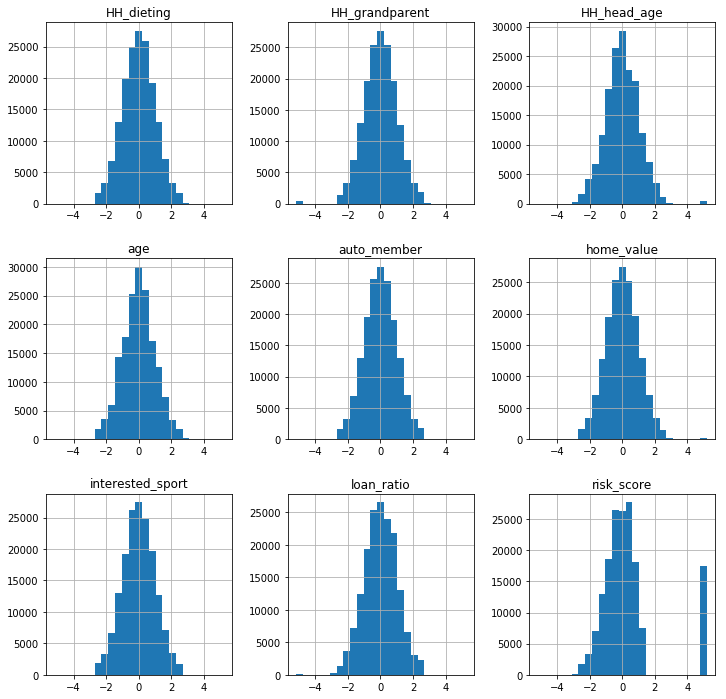

In [29]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=100, output_distribution='normal')
qt_data = qt.fit_transform(travel[continuous_cols])

pd.DataFrame(qt_data, columns=continuous_cols).hist(bins=25,figsize=(12,12))
plt.show()

#### 标准化

- 对有多个水平的有序分类变量进行标准化

如前所述，尽管HH_adults_num、marital和interest属于连续变量，但都仅有不到10个水平，因此与有序分类变量一样，仅做标准化

In [30]:
from sklearn.preprocessing import scale

scale_data = scale(travel[categorical_cols])

- 对二分类变量不做处理，合并各类型的变量

In [31]:
data = np.hstack([qt_data, scale_data, travel[discreate_cols]])
data = pd.DataFrame(
    data, columns=continuous_cols + categorical_cols + discreate_cols)

In [32]:
data.head()

,age,home_value,risk_score,interested_sport,HH_dieting,auto_member,HH_grandparent,HH_head_age,loan_ratio,marital,interest,HH_adults_num,HH_has_children
0,0.321971,-0.891380,0.589456,0.742289,-0.515705,0.848859,0.261573,2.508596,0.698526,-1.487818,-1.035281,-0.547836,0.0
1,0.619855,-0.622970,5.199338,-0.139710,0.834427,1.080449,1.174351,0.458679,0.698526,0.044429,-0.354828,1.895118,0.0
2,-0.126937,-0.465122,-0.938624,1.324958,0.525369,-0.814106,-0.446657,-0.229884,1.549706,-2.253942,-1.035281,-0.547836,0.0
3,1.335178,-0.253425,0.589456,0.501298,0.114185,-0.178175,1.403413,1.639976,0.927754,0.044429,1.686529,-0.547836,1.0
4,-0.747859,-0.710696,1.144237,-1.816693,0.225553,-0.408607,-0.932632,-0.987837,1.549706,1.193615,1.006077,0.266482,1.0


#### 连续变量筛选

强相关的连续变量可能会造成聚类结果过于注重某个方面的信息,因此需要进行处理。根据业务需求，将变量从三个大的维度进行考虑：其一为用户家庭属性(包括家庭基本情况)；其二为用户个人偏好情况（包括对运动、节食的兴趣程度）；其三为用户的财产情况

In [37]:
data.corr()

,age,home_value,risk_score,interested_sport,HH_dieting,auto_member,HH_grandparent,HH_head_age,loan_ratio,marital,interest,HH_adults_num,HH_has_children
age,1.000000,-0.133694,0.267452,0.160194,-0.055827,0.350007,0.556617,0.618342,-0.227111,-0.018801,0.256020,0.119455,-0.403201
home_value,-0.133694,1.000000,0.079103,0.399960,0.073282,0.449907,-0.346547,-0.145901,-0.412084,0.315808,0.024202,0.087076,0.129110
risk_score,0.267452,0.079103,1.000000,0.227483,-0.010365,0.228718,0.105365,0.204033,-0.143463,-0.004017,0.063736,0.015966,-0.114433
interested_sport,0.160194,0.399960,0.227483,1.000000,0.510891,0.458516,0.003352,0.069188,-0.278363,0.046513,0.219894,0.067951,-0.042603
HH_dieting,-0.055827,0.073282,-0.010365,0.510891,1.000000,0.134140,-0.011754,-0.204909,-0.050122,-0.052969,0.246519,0.072987,0.099203
auto_member,0.350007,0.449907,0.228718,0.458516,0.134140,1.000000,0.144258,0.259482,-0.436571,0.274574,0.316723,0.160750,-0.142744
HH_grandparent,0.556617,-0.346547,0.105365,0.003352,-0.011754,0.144258,1.000000,0.564404,-0.052211,-0.182748,0.232263,0.040176,-0.395464
HH_head_age,0.618342,-0.145901,0.204033,0.069188,-0.204909,0.259482,0.564404,1.000000,-0.101731,-0.150501,0.065948,0.003917,-0.333558
loan_ratio,-0.227111,-0.412084,-0.143463,-0.278363,-0.050122,-0.436571,-0.052211,-0.101731,1.000000,-0.223805,-0.157765,-0.178513,0.036007
marital,-0.018801,0.315808,-0.004017,0.046513,-0.052969,0.274574,-0.182748,-0.150501,-0.223805,1.000000,0.247610,0.469695,0.376839


如果以0.6作为相关系数的上限。在相关系数矩阵中,发现'age'和 'HH_head_age'的相关系数超过0.6，因此决定, 'HH_head_age'不参与聚类运算.

In [38]:
household = ['age', 'marital', 'HH_adults_num', 'HH_has_children','HH_grandparent']
finance = ['home_value', 'risk_score', 'loan_ratio']
hobby = ['HH_dieting', 'auto_member', 'interest', 'interested_sport']

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster_plot(data, k_range=range(2, 12), n_init=5, sample_size=2000, 
                 n_jobs=-1):
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=n_init, n_jobs=n_jobs)
        kmeans.fit(data)
        sil = silhouette_score(data, kmeans.labels_, 
                               sample_size=sample_size)
        scores.append([k, kmeans.inertia_, sil])

    scores_df = pd.DataFrame(scores, columns=['k','sum_square_dist', 'sil'])
    plt.figure(figsize=[9, 2])
    plt.subplot(121, ylabel='sum_square')
    plt.plot(scores_df.k, scores_df.sum_square_dist)
    plt.subplot(122, ylabel='silhouette_score')
    plt.plot(scores_df.k, scores_df.sil)
    plt.show()

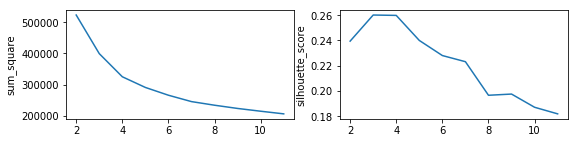

In [40]:
cluster_plot(data[household])

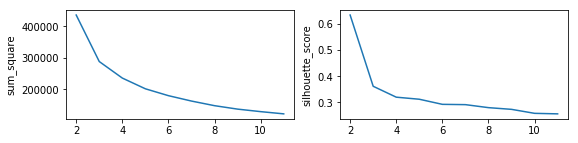

In [41]:
cluster_plot(data[finance])

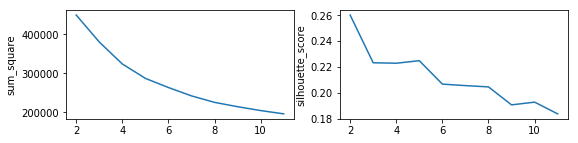

In [42]:
cluster_plot(data[hobby])

In [43]:
def k_means(data, k=2, n_init=5, n_jobs=-1):
    model = KMeans(n_clusters=k, n_init=n_init, n_jobs=n_jobs)
    model.fit(data)
    return model.labels_

household_labels = k_means(data[household], k=4)
finance_labels = k_means(data[finance], k=2)
hobby_labels = k_means(data[hobby], k=2)

label_names = ['HH', 'finance', 'hobby']
labels = np.vstack([household_labels, finance_labels, hobby_labels]).T
travel_labels = travel.join(pd.DataFrame(labels, columns=label_names))

In [45]:
travel_labels.head()

,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,HH_has_children,HH_adults_num,interest,HH,finance,hobby
0,64,124035,73,932,3,312,420,149,96,626,0,2.0,0.2,3,0,1
1,69,138574,73,1000,7,241,711,263,68,658,0,5.0,0.4,0,1,1
2,57,148136,77,688,1,367,240,240,56,354,0,2.0,0.2,3,0,1
3,80,162532,74,932,7,291,832,197,86,462,1,2.0,1.0,2,0,1
4,48,133580,77,987,10,137,121,209,42,423,1,3.0,0.8,1,0,0


#### 对各个簇的特征进行描述——使用原始数据

In [48]:
travel_labels.groupby('hobby')[hobby].mean()

travel_labels.groupby('HH')[household].mean()

,age,marital,HH_adults_num,HH_has_children,HH_grandparent
HH,,,,,
0,61.690167,8.895928,4.541311,0.298564,379.021862
1,47.965625,8.623593,2.347670,0.677457,150.337997
2,72.366704,6.752651,2.386443,0.085234,599.657194
3,52.750795,3.360244,1.768124,0.133085,321.652942


In [49]:
travel_labels.groupby('hobby')[hobby].mean()

,HH_dieting,auto_member,interest,interested_sport
hobby,,,,
0,164.685065,398.820625,0.349791,209.423287
1,242.912062,571.395242,0.652639,307.448415


In [50]:
travel_labels.groupby('finance')[finance].mean()

,home_value,risk_score,loan_ratio
finance,,,
0,208894.552357,795.609348,66.924025
1,196746.622018,1000.000000,65.384888
